<a href="https://colab.research.google.com/github/Jeremstar/business_is_business/blob/main/rendu_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **La Hiérarchie du Covid :**
## *Application d'un modèle hiérarchique bayésien dans le cas du Covid*
---

Jérémi Bornet, Paul Dupire, Simon Genet

##Résumé
L'objectif que s'est donné Benjamin Riu est la conception d'un modèle multi-niveaux bayésien qui permet de réaliser des prédictions sur les données temporelles de commerce en ligne. Un modèle multi-niveaux se conçoit comme une imbrication de différents modèles : il effectue une première régression simple à partir de laquelle il prédit une première variable, puis il injecte le résultat dans un deuxième modèle, et ainsi de suite. 

Pour notre part, nous avons décidé de transposer son travail aux données Covid britanniques. 

Nous avons utilisé la libraire pystan conformément aux consignes. C 'était la principale consigne quant à la réalisation de notre projet. Il s'agit d'une librairie statistique qui facilite la création de modèles complexes.

# Introduction 

Le projet vise à créer un modèle hiérarchique de série temporelle à partir des données relatives à la pandémie de Covid au Royaume-Uni. Ce modèle vise à prédire in fine le nombre de tests positifs à partir du nombre de tests par jour. Nous disposons de 2 variables : le nombre de tests par jour (**new_virus_test**) et  le nombre de tests positifs par jour (**daily_cases**). Nous disposons de 1065 données (J). Nos données s'étendent de 2020 à 2023. 

Voici l'allure du jeu de données une fois nettoyé :


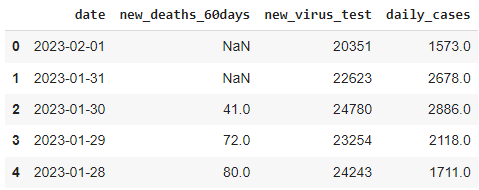

# Le Modèle 

Le modèle correspond de manière simplifiée à celui présenté par Monsieur Benjamin Riu dans le cadre du séminaire de modélisation statistique. Notre modèle sera constitué de 2 niveaux et portera sur nos deux variables dont vous trouverez ci-dessous les correspondances avec celles du mémoire de M. Riu : 

- **$S_{j}$** : le nombre de tests (**new_virus_test**) pour le jour j $ \in $ $J$ = 1065  qui correspond au nombre de sessions dans le mémoire ; 
- **$T_{j}$** : le nombre de tests positifs (**daily_cases**)  pour le jour j $ \in $  $J$ = 1065 qui correspond au nombre de transactions ;


Contrairement au modèle de M. Riu nous ne disposons pas de 3 types de produits ($H$ = 1) 

## Matrice design (mat_design)

Nous reprenons ici la méthodologie décrite par M. Riu en transformant la date littérale en un jour j, puis nous introduisons le même vecteur temporel qui rend compte de la tendance linéaire, la saisonalité hebdomadaire de période $\tau_{1}$ = 7 et la saisonalité annuelle de période $\tau_{2}$ = 365,25. On note : 

$x_{j} = (x_{j}^0,..., x_{j}^{P^*})^T$

où $P^*$ = 45 

- Soit $x_{j}^0$ = 1 qui correspond à l'intercept : point de départ ou facteur de mise à l'échelle;
- Soit $x_{j}^1 = \frac{j}{365 \times 3}$ qui correspond à la tendance linéaire. Nous avons gardé car nos données sont à peu près sur 3 ans;
- Pour décrire les évolutions hebdomadaires, nous reprenons les résultats des séries de Fourier du mémoire : pour $l = 2,...,8$ on a $x_{j}^l = \cos{\frac{2\pi(l-2)j}{\tau_{1}}}$ ; et pour $l = 9,...,15$, on a on a $x_{j}^l = \sin{\frac{2\pi(l-9)j}{\tau_{1}}}$;
- De même pour décrire les évolutions annuelles, nous reprenons les résultats des séries de Fourier du mémoire : pour $l = 16,...,30$ on a $x_{j}^l = \cos{\frac{2\pi(l-16)j}{\tau_{2}}}$ ; et pour $l = 31,...,45$, on a on a $x_{j}^l = \sin{\frac{2\pi(l-31)j}{\tau_{2}}}$ .


Nous obtenons ainsi une matrice $X_{j}$  de taille $J \times P$ avec $P = P^* + 1$  telle que : 
 $X_{J} = \pmatrix{x_{0}^T \\ x_{1}^T \\ ... \\ x_{J}^T}$.


## Nos trois régressions 

Notre modèle est constitué de 2 niveaux différents qui reprennent les mêmes lois que M. Riu et que nous adaptons dans cette partie.

### Régression 1 (R1) : Modèle Binomiale-négative-log

Le modèle R1 permet de modéliser le nombre de test par jour $S_{j}$, à partir de la matrice design $X_{J}$. Soit $S_{j}$ $ \in \mathbb{N}$ le nombre de test par jour. On pose similéairement au mémoire : 


<div style="text-align:center;"> $\mu_{j}^{(1)}:= exp( x_{j}^T \theta^{(1)})$ </div>

<div style="text-align:center;"> $S_{j} \sim negbin( \mu_{j}^{(1)}, \sigma^{(1)})$ </div>

où $\theta^{(1)} \in \mathbb{R}^P$ et $\sigma^{(1)} \in \mathbb{R}_{+}^*$ sont des paramètres à estimer. 


Pour trouver $\hat{\theta^{(1)}}$ de $\theta^{(1)}$, nous réalisons une régression negbinomiale de $S$ sur $X_{J}$ :

<div style="text-align:center;"> $\log{(\hat{S})} = \hat{\beta} \log{(X_{J})} + \hat{\epsilon}$ </div>

On obtient ainsi $\hat{\theta^{(1)}} = \hat{\beta} \in \mathbb{R}^P$ que l'on peut ensuite injecter dans notre modèle.


Pour $\sigma^{(1)} \in \mathbb{R}_{+}^*$, on se reporte au mémoire en le sélectionnant tel que  $\frac{1}{\sigma^{(1)}} \sim \mathcal{N}(0,\, 0.5), \, \sigma^{(1)} > 0 $.


Voici les résultats que l'on obtient :


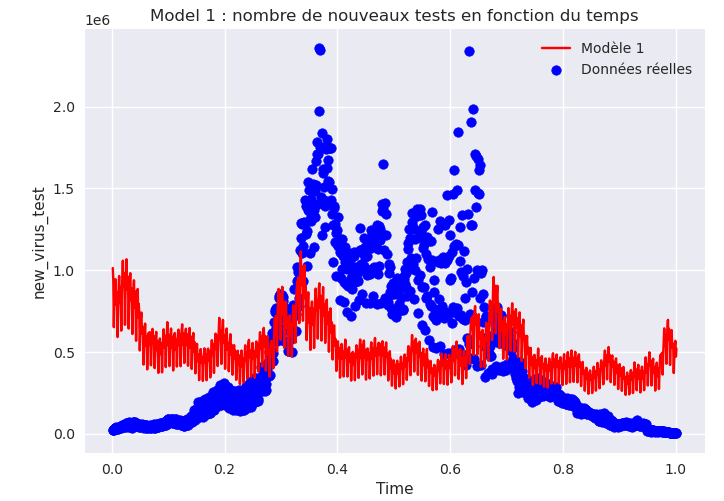

**Commentaires :** Nous remarquons que pour ce modèle, nos prédictions ne suivent pas totalement les évolutions du nombre de nouveaux tests par jour notamment aux extrémités temporelles de notre base de données. Cela s'explique par le fait que d'autres facteurs sont responsables du nombre de tests par jour que le facteur saisonnier/temporel. Ainsi, en 2020, le manque de tests conduit nécessairement à une moins forte propension de nouveaux tests. De même, le gouvernement britannique ayant arrêté la gratuité des tests Covid PCR à partir du 1er avril 2022, cela a pu réduire le nombre de nouveaux tests par jour. De ce fait, d'autres facteurs exogènes peuvent expliquer le nombre de nouveaux tests ce qui expliquerait que le modèle suive globalement les évolutions au "milieu" de la pandémie mais pas à son commencement, ni en ce moment.  

### Régression 2 (R2) : Modèle Bétabinomiale-logit

Le modèle R2 permet de modéliser le nombre de test positif par jour $T_{j}$, à partir de la matrice design $X_{J}$ et des valeurs des $S_{j}$  provenant de la première régression. Soit $T_{j} \in [0 , \, ... , \, S_{j}]$ le nombre de test positif par jour. On pose similairement au mémoire : 



<div style="text-align:center;"> $\mu_{j}^{(2)}:= \frac{1}{1 + exp( - x_{j}^T \theta^{(2)})}$ </div>
<div style="text-align:center;"> $\alpha_{j}^{(2)}:= \mu_{j}^{(2)} \times  \sigma^{(2)} $ </div>
<div style="text-align:center;"> $\beta_{j}^{(2)}:= (1 - \mu_{j}^{(2)}) \times  \sigma^{(2)} $ </div>

<div style="text-align:center;"> $T_{j} | S_{j} \sim betabin(\alpha_{j}^{(2)}, \beta_{j}^{(2)}, S_{j})$ </div>



où $\theta^{(2)} \in \mathbb{R}^P$ et $\sigma^{(2)} \in \mathbb{R}_{+}^*$ sont des paramètres à estimer. 

Pour trouver $\hat{\theta^{(2)}}$ de $\theta^{(2)}$, nous réalisons une régression logit bétabinomiale de $T$ sur $X_{J}$ :

<div style="text-align:center;"> $logit(\hat{T}) = \hat{\beta} logit(X_{J}) + \hat{\epsilon}$ </div>

On obtient ainsi $\hat{\theta^{(2)}} = \hat{\beta} \in \mathbb{R}^P$ que l'on peut ensuite injecter dans notre modèle.

Pour $\sigma^{(2)} \in \mathbb{R}_{+}^*$, on se reporte au mémoire en sélectionnant un tel que  $\ln{(\sigma^{(2)})} \sim \mathcal{N}(0,\, 0.5), \, \sigma^{(2)} > 0 $.


Voici les résultats de cette seconde régression :


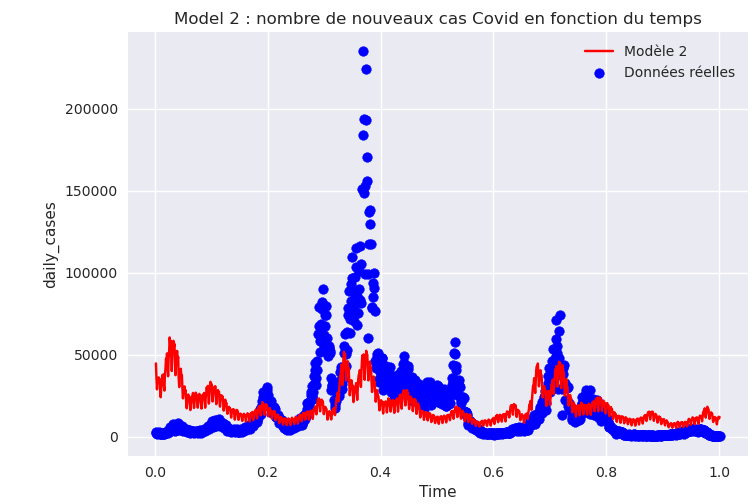

**Commentaires :** Nous remarquons que malgré les défauts du premier modèle, celui-ci décrit assez bien les évolutions du nombre de cas positif du Covid (en particulier à partir de t > 0.2). Ainsi, même si nos prédictions ne collent pas exactement aux données, on observe qu'elles suivent les évolutions et les pics de cas positifs. De même, que pour le premier modèle, on remarque que c'est notamment au début de l'épidémie que notre modèle ne suit pas les données réelles. Cela peut s'expliquer par le fait que le nombre de nouveaux tests par jour est mal expliqué par le modèle 1. 

##Conclusion
La mise en place de ce projet a été pour nous l'occasion de découvrir et manipuler la librairie pystan. Elle nous a semblé assez performante pour mettre en place des modèles multi-niveaux.

Ce sont des modèles que nous avons également découvert par le biais de ce projet, et dont le champ des applications nous semble très étendu. 

Les différences que l'on observe sur nos graphiques proviennent de la spécificité de nos données, puisque le modèle de Benjamin Riu est plutôt adapté à des données de comemrce en ligne. Pour autant, les écarts entre les prédictions du modèle et les données réelles restent raisonnables et encourageants.

###Difficultés
Pystan est une librairie qui évolue beaucoup, au fil des mises à jour régulières, et certaines syntaxes peuvent changer. De fait, l'utilisation des forums d'aide en ligne a pu être assez délicate. Les premiers modèles que nous avons réussi à concevoir n'exploitaient donc pas toutes les capacités de pystan puisque nous étions bloqués par le langage. Nous obtenions alors des prédictions aberrantes.

La matrice design étant quelque chose de nouveau pour nous, nous avons également passé du temps à sa compréhension.

Nous tenons à remercier notre encadrant Benjamin Riu pour sa bienveillance et sa disponibilité tout au long du projet, qui nous a permis de dépasser les difficultés que nous venons d'évoquer. L'atmosphère et l'ambiance de travail étaient très bonnes avec une solide entente au sein du groupe.

# Code 

A la demande de M. Riu nous utilisons la librairie pystan pour construire les modèles.

In [ ]:
%%capture
!pip install prophet
!pip install stan
!pip install pystan
!pip install nest_asyncio

In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import stan
import nest_asyncio
nest_asyncio.apply()

## Préparation des données 

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Jeremstar/business_is_business/main/England_covid.csv')
df.head()

,date,area_type,area_name,daily_cases,cum_cases,new_deaths_28days,cum_deaths_28days,new_deaths_60days,cum_deaths_60days,new_first_episode,...,new_third_dose,cum_third_dose,new_admissions,cum_admissions,hospital_cases,ventilator_beds,trans_rate_min,trans_rate_max,trans_growth_min,trans_growth_max
0,2023-02-01,nation,England,1573.0,20535061.0,NaN,NaN,NaN,NaN,892.0,...,625.0,33356701.0,NaN,NaN,6055.0,136.0,NaN,NaN,NaN,NaN
1,2023-01-31,nation,England,2678.0,20533488.0,NaN,NaN,NaN,NaN,1564.0,...,587.0,33356076.0,NaN,NaN,6015.0,136.0,NaN,NaN,NaN,NaN
2,2023-01-30,nation,England,2886.0,20530810.0,30.0,180801.0,41.0,226052.0,1724.0,...,613.0,33355489.0,741.0,958745.0,5959.0,142.0,NaN,NaN,NaN,NaN
3,2023-01-29,nation,England,2118.0,20527924.0,44.0,180771.0,72.0,226011.0,1224.0,...,247.0,33354876.0,705.0,958004.0,5834.0,145.0,NaN,NaN,NaN,NaN
4,2023-01-28,nation,England,1711.0,20525806.0,47.0,180727.0,80.0,225939.0,1119.0,...,1326.0,33354629.0,562.0,957299.0,5750.0,140.0,NaN,NaN,NaN,NaN


In [ ]:
#Nettoyage des données
df = df[["date", "new_deaths_60days","new_virus_test","daily_cases"]]
df.head()

,date,new_deaths_60days,new_virus_test,daily_cases
0,2023-02-01,NaN,20351,1573.0
1,2023-01-31,NaN,22623,2678.0
2,2023-01-30,41.0,24780,2886.0
3,2023-01-29,72.0,23254,2118.0
4,2023-01-28,80.0,24243,1711.0


In [ ]:
%%capture
df.std()

In [ ]:
missing = df.isnull().sum()
print(missing)
print(df.size)

#On décide d'enlever les valeurs manquantes
df = df.dropna(axis=0)
df.head()

date                  0
new_deaths_60days    61
new_virus_test        0
daily_cases          27
dtype: int64
4504


,date,new_deaths_60days,new_virus_test,daily_cases
2,2023-01-30,41.0,24780,2886.0
3,2023-01-29,72.0,23254,2118.0
4,2023-01-28,80.0,24243,1711.0
5,2023-01-27,97.0,31287,2189.0
6,2023-01-26,119.0,37446,2250.0


In [ ]:
#On transforme la date en donnée incrémentale 
df = df.sort_values(by='date')
df['j'] = np.arange(df.shape[0])
df["j"] = df['j'] + 1
df.tail()

,date,new_deaths_60days,new_virus_test,daily_cases,j
6,2023-01-26,119.0,37446,2250.0,1061
5,2023-01-27,97.0,31287,2189.0,1062
4,2023-01-28,80.0,24243,1711.0,1063
3,2023-01-29,72.0,23254,2118.0,1064
2,2023-01-30,41.0,24780,2886.0,1065


## Construction de la matrice design

In [ ]:
#fonction pour implémenter la matrice design à partir de j (voir mémoire pour la méthodologie). Elle prend un j et retourne le vecteur associé. 
def find_var_expl_time(j): 
    x_j = [1]
    x_j.append(j/365*3)
    for l in range(2,46): 
        if l >= 2 and l <= 8: 
            x_j.append(math.cos(2*math.pi*(l-2)*j/7))
        elif l >= 9 and l <= 15:
            x_j.append(math.sin(2*math.pi*(l-9)*j/7))
        elif l >= 16 and l <= 30: 
            x_j.append(math.cos(2*math.pi*(l-16)*j/(365.25)))
        elif l >= 31 and l <= 45:
            x_j.append(math.sin(2*math.pi*(l-35)*j/(365.25)))
    return x_j

In [ ]:
#Construction de la matrice design à partir de la fonction précèdente. 
mat_design = np.empty((0,46))
for j in df["j"]:
    row = np.array(find_var_expl_time(j))
    mat_design = np.r_[mat_design,[row]]

#mat_design = pd.DataFrame(mat_design)

In [ ]:
mat_design

array([[1.00000000e+00, 8.21917808e-03, 1.00000000e+00, ...,
        1.37185404e-01, 1.54204048e-01, 1.71177060e-01],
       [1.00000000e+00, 1.64383562e-02, 1.00000000e+00, ...,
        2.71776738e-01, 3.04719233e-01, 3.37301069e-01],
       [1.00000000e+00, 2.46575342e-02, 1.00000000e+00, ...,
        4.01228985e-01, 4.47944939e-01, 4.93468142e-01],
       ...,
       [1.00000000e+00, 8.73698630e+00, 1.00000000e+00, ...,
        9.78988874e-01, 9.36590583e-01, 6.04701877e-01],
       [1.00000000e+00, 8.74520548e+00, 1.00000000e+00, ...,
        9.41758934e-01, 9.79425086e-01, 7.32110943e-01],
       [1.00000000e+00, 8.75342466e+00, 1.00000000e+00, ...,
        8.86721063e-01, 9.98829828e-01, 8.37908509e-01]])

In [ ]:
Time = df.shape[0]
t = np.array(df.index).reshape(-1, 1) / Time

### Régression 1 du Modèle 1 

On implemente le modèle de la negbinomiale. 

In [ ]:
Model = """
data {
  int N; //nombre de données 
  int S[N]; //nombre de tests Covid
  int K; // nombre de colonnes de la matrice design
  matrix[N,K]  X; //mat_design
  // priors
  real inv_sigma_scale; // borne sup de la loi normale que suit l'inverse du sigma (voir mémoire) 
}

parameters {
  vector[K] theta ;
  real inv_sigma; //inverse du sigma
  real<lower=0, upper=1> alpha;
  real<lower=0> lambda;
}
transformed parameters {
  vector[N] mu; //
  real sigma; //
  sigma = 1. / inv_sigma;
  mu = exp(X*theta);
}
model {
  inv_sigma ~ normal(0. , inv_sigma_scale);
  theta[1] ~ cauchy(0,10); //prior pour l'intercept suivant la méthode de Gelman 2008
  for(i in 2:K) {
   theta[i] ~ cauchy(0,2.5);//prior pour la courbe  suivant la méthode de Gelman 2008
   }
  for (i in 1:N) {
    S[i] ~ neg_binomial_2(mu[i], sigma);
  }
}
generated quantities {
  array[N] real  S_rep;
  for (i in 1:N) {
    S_rep[i] = neg_binomial_2_rng(mu[i], sigma);
}
}

"""

In [ ]:
%%capture
Data = {"S": list(df["new_virus_test"]),
                "N": len(df["new_virus_test"]),
                "K" : mat_design.shape[1],
                "X": mat_design,
                "inv_sigma_scale" : 0.5
       }


posterior = stan.build(Model, data=Data)
fit = posterior.sample(num_chains=4, num_samples=1000)

df2 = fit.to_frame()  # pandas `DataFrame`

In [ ]:
mat_design.shape

(1065, 46)

In [ ]:
print(fit)

<stan.Fit>
Parameters:
    theta: (46,)
    inv_sigma: ()
    alpha: ()
    lambda: ()
    mu: (1065,)
    sigma: ()
    S_rep: (1065,)
Draws: 4000


In [ ]:
df2

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta.1,theta.2,theta.3,...,S_rep.1056,S_rep.1057,S_rep.1058,S_rep.1059,S_rep.1060,S_rep.1061,S_rep.1062,S_rep.1063,S_rep.1064,S_rep.1065
draws,,,,,,,,,,,,,,,,,,,,,
0,-14342.210315,0.878669,0.027923,6.0,86.0,1.0,14362.459514,-0.813447,0.087814,10.402774,...,407992.0,2021892.0,1086123.0,407943.0,1481067.0,1438570.0,137485.0,1124931.0,1569291.0,301540.0
1,-14356.619010,0.960316,0.015099,5.0,32.0,1.0,14387.427770,17.624421,0.041295,1.224409,...,985529.0,807825.0,5042924.0,1147566.0,157999.0,1524571.0,294222.0,1044316.0,168377.0,564380.0
2,-14332.010206,0.000000,0.027325,0.0,1.0,1.0,14353.887967,6.674438,0.055793,10.166906,...,185696.0,498199.0,1362261.0,2934.0,4595771.0,327579.0,1660941.0,609016.0,963362.0,179115.0
3,-14342.296047,0.890777,0.031477,6.0,124.0,1.0,14367.777113,8.204306,0.076291,0.189130,...,891088.0,690351.0,3653.0,35183.0,12147.0,960144.0,620090.0,968587.0,397941.0,135547.0
4,-14341.565001,0.963519,0.027923,6.0,93.0,1.0,14363.734169,-0.638706,0.075597,10.304814,...,536722.0,736563.0,1304148.0,233376.0,428129.0,329202.0,644898.0,777968.0,340328.0,986234.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-14340.620812,0.891040,0.031477,6.0,113.0,1.0,14360.696344,9.831677,0.041489,3.112225,...,380550.0,24031.0,122602.0,63497.0,31488.0,35550.0,1779884.0,1388296.0,478687.0,1250687.0
3996,-14332.456126,0.929013,0.027923,5.0,43.0,1.0,14360.528580,12.786427,0.004329,-0.400244,...,362850.0,3849617.0,1763245.0,690883.0,1409046.0,1299079.0,647755.0,654153.0,1337468.0,738281.0
3997,-14334.494712,0.947869,0.015099,5.0,60.0,1.0,14364.714365,-11.495552,0.060761,2.164902,...,435591.0,120905.0,1146823.0,110852.0,41512.0,3588.0,2310579.0,679127.0,1042404.0,4395782.0


In [ ]:
df_S_rep = df2.loc[:, "S_rep.1":"S_rep.1065"]
df_S_rep

parameters,S_rep.1,S_rep.2,S_rep.3,S_rep.4,S_rep.5,S_rep.6,S_rep.7,S_rep.8,S_rep.9,S_rep.10,...,S_rep.1056,S_rep.1057,S_rep.1058,S_rep.1059,S_rep.1060,S_rep.1061,S_rep.1062,S_rep.1063,S_rep.1064,S_rep.1065
draws,,,,,,,,,,,,,,,,,,,,,
0,1165941.0,9248.0,929095.0,53508.0,238484.0,141017.0,386621.0,1635795.0,34953.0,912531.0,...,407992.0,2021892.0,1086123.0,407943.0,1481067.0,1438570.0,137485.0,1124931.0,1569291.0,301540.0
1,117065.0,180547.0,636061.0,1373201.0,737475.0,713442.0,1229943.0,233369.0,1172314.0,19062.0,...,985529.0,807825.0,5042924.0,1147566.0,157999.0,1524571.0,294222.0,1044316.0,168377.0,564380.0
2,127942.0,1464968.0,1974913.0,359621.0,67615.0,4330.0,1531665.0,103456.0,910981.0,515415.0,...,185696.0,498199.0,1362261.0,2934.0,4595771.0,327579.0,1660941.0,609016.0,963362.0,179115.0
3,392257.0,88298.0,377378.0,278660.0,16567.0,12368.0,72438.0,693672.0,166075.0,432526.0,...,891088.0,690351.0,3653.0,35183.0,12147.0,960144.0,620090.0,968587.0,397941.0,135547.0
4,4150.0,113827.0,1490609.0,1373490.0,189391.0,501433.0,378401.0,801287.0,1351215.0,90721.0,...,536722.0,736563.0,1304148.0,233376.0,428129.0,329202.0,644898.0,777968.0,340328.0,986234.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,13912.0,64817.0,263110.0,178694.0,622599.0,700350.0,110480.0,31262.0,1239006.0,135461.0,...,380550.0,24031.0,122602.0,63497.0,31488.0,35550.0,1779884.0,1388296.0,478687.0,1250687.0
3996,92143.0,382360.0,495402.0,69827.0,465323.0,110035.0,379704.0,231218.0,180411.0,691917.0,...,362850.0,3849617.0,1763245.0,690883.0,1409046.0,1299079.0,647755.0,654153.0,1337468.0,738281.0
3997,729523.0,1504495.0,80649.0,854775.0,59534.0,381056.0,67071.0,1866748.0,634637.0,75351.0,...,435591.0,120905.0,1146823.0,110852.0,41512.0,3588.0,2310579.0,679127.0,1042404.0,4395782.0


In [ ]:
df_S_rep.mean().values

array([ 519055.0855 ,  471114.14225,  567910.034  , ...,  651360.35325,
        937416.16025, 1012869.3585 ])

/tmp/ipykernel_499/4076474129.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


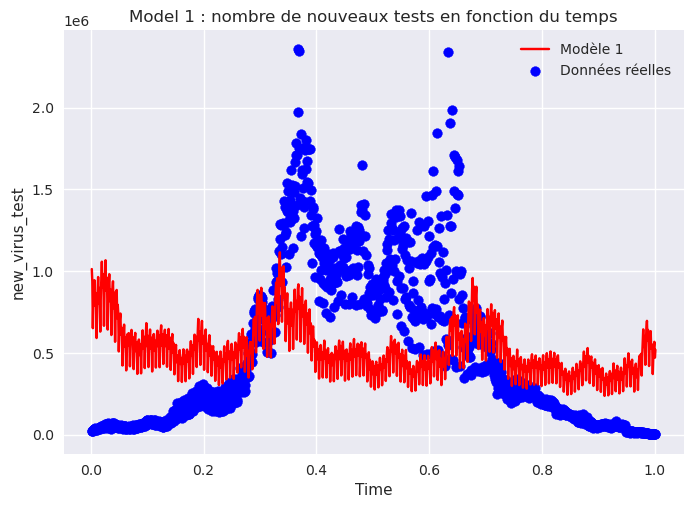

In [ ]:
plt.style.use('seaborn')
plt.plot(t, df_S_rep.mean().values, color='red', label = 'Modèle 1')
plt.scatter(t,df["new_virus_test"], color='blue', label = 'Données réelles')
plt.xlabel('Time')
plt.ylabel('new_virus_test')
plt.title('Model 1 : nombre de nouveaux tests en fonction du temps')
plt.legend()
plt.show()

### Deuxième régression

On implémente le deuxième modèle, qui se superpose au premier. Attention le modèle 2 prend beaucoup de temps à tourner. 

In [ ]:
Model = """

data {
    int N; // nombre de données
    int S[N]; // nombre de sessions estimées par la régression 1
    int T[N]; // nombre de tests positifs
    int K; // nombre de colonnes de la matrice design
    matrix[N, K] X; // la matrice design
    //priors
    real log_sigma_scale; // variance de la loi normale que suit le log de sigma
}

parameters {
    real log_sigma; //log de sigma;
    vector[K] theta;
}

transformed parameters {
    real sigma; //
    vector[N] mu; //
    vector[N] alpha;
    vector[N] beta;
    
    sigma = exp(log_sigma);
    for(n in 1:N) {
        mu[n] = inv_logit(X[n,]*theta);
        }
    alpha = mu * sigma;
    beta = (1-mu) * sigma;
    
}

model {
    log_sigma ~ normal(0. , log_sigma_scale);
    
    theta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008
    for(i in 2:K) {
        theta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008
    }
    for (i in 1:N) {
        T[i] ~ beta_binomial(S[i], alpha[i], beta[i]);
  }
}

generated quantities {
    array[N] real T_rep;
    for(n in 1:N){
        T_rep[n] = beta_binomial_rng(S[n],alpha[n],beta[n]); //posterior draws to get posterior predictive checks
    }
}
"""

In [ ]:
%%capture
Data = {
        "T": [int(nombre) for nombre in df["daily_cases"].values.tolist()],
        "S": [int(abs(nombre)) for nombre in df_S_rep.mean().values],
        "N": len(df_S_rep.mean().values),
        "K" : mat_design.shape[1],
        "X": mat_design,
        "log_sigma_scale" : 0.5
}


posterior = stan.build(Model, data=Data)
fit = posterior.sample(num_chains=4, num_samples=1000)

df3 = fit.to_frame()  # pandas `DataFrame`

In [ ]:
print(fit)

<stan.Fit>
Parameters:
    log_sigma: ()
    theta: (46,)
    sigma: ()
    mu: (1065,)
    alpha: (1065,)
    beta: (1065,)
    T_rep: (1065,)
Draws: 4000


In [ ]:
df_T_rep = df3.loc[:, "T_rep.1":"T_rep.1065"]

/tmp/ipykernel_499/923276883.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


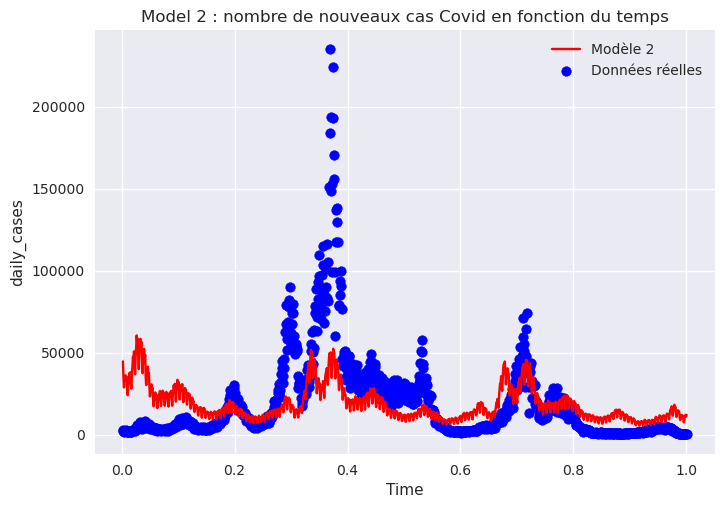

In [ ]:
plt.style.use('seaborn')
plt.plot(t, df_T_rep.mean().values, color='red', label = "Modèle 2")
plt.scatter(t,df["daily_cases"], color='blue', label = "Données réelles")
plt.xlabel('Time')
plt.ylabel('daily_cases')
plt.title('Model 2 : nombre de nouveaux cas Covid en fonction du temps')
plt.legend()
plt.show()